## Optimization-Based Identification Methods for General Input-Output Model
This notebook demonstrates the use of optimization-based identification methods for general input-output models.

In [12]:
# Import required libraries
import numpy as np
from control import frequency_response
from control.timeresp import step_response
from sklearn.metrics import explained_variance_score, root_mean_squared_error
from sklearn.pipeline import Pipeline

from sippy_unipi.datasets import load_sample_siso
from sippy_unipi.io import ARARMAX, ARARX, ARMA, BJ, GEN, OE
from sippy_unipi.plot import (
    plot_bode,
    plot_response,
    plot_responses,
)
from sippy_unipi.preprocessing import StandardScaler

np.random.seed(0)
ylegends = ["System", "ARMA", "ARARX", "ARARMAX", "OE", "BJ", "GEN"]

# Enable automatic reloading of modules when they change
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


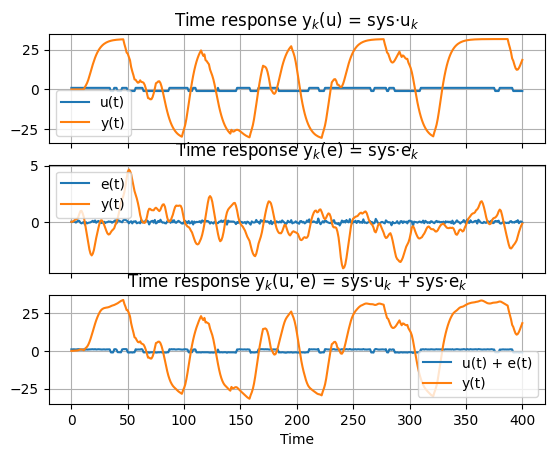

In [13]:
# Load sample data
n_samples = 401
ts = 1.0
time, Ysim, Usim, g_sys, Yerr, Uerr, h_sys, Ytot, Utot = load_sample_siso(
    n_samples, ts, seed=0
)

# Plot input and output responses
fig = plot_responses(
    time,
    [Usim, Uerr, Utot],
    [Ysim, Yerr, Ytot],
    ["u", "e", ["u", "e"]],
)

In [26]:
na = 2
nb = 3
nc = 2
nd = 3
nf = 4
theta = 11
stab_cons = False
method = "opt"
models = [
    ARMA(na, nc, theta, stab_cons=stab_cons, method=method),
    ARARX(na, nb, nd, theta, stab_cons=stab_cons, method=method),
    ARARMAX(na, nb, nc, nd, theta, stab_cons=stab_cons, method=method),
    OE(nb, nf, theta, stab_cons=stab_cons, method=method),
    BJ(nb, nc, nd, nf, theta, stab_cons=stab_cons, method=method),
    GEN(na, nb, nc, nd, nf, theta, stab_cons=stab_cons, method=method),
]

In [27]:
ys = [Ytot]
scores = {"rmse": [], "ev": []}
fitted_models = []
for model in models:
    sys = Pipeline(
        [
            ("scaler", StandardScaler(with_mean=False)),
            ("model", model),
        ]
    )
    sys.fit(Utot.reshape(-1, 1), Ytot.reshape(-1, 1))
    fitted_models.append(sys)
    Y_pred = sys.predict(Utot.reshape(-1, 1), safe=True)
    scores["rmse"].append(root_mean_squared_error(Ytot, Y_pred))
    scores["ev"].append(explained_variance_score(Ytot, Y_pred))
    ys.append(Y_pred)

In [32]:
# Print scores in a formatted table
print("Model Performance Metrics:")
print("-" * 50)
print(f"{'Model':<20} {'RMSE':<10} {'Explained Variance':<20}")
print("-" * 50)

for i, model_name in enumerate(ylegends):
    if i == 0:  # Skip the first one which is the actual data
        continue
    rmse_value = scores["rmse"][i - 1]
    ev_value = scores["ev"][i - 1]
    print(f"{model_name:<20} {rmse_value:<10.4f} {ev_value:<20.4f}")
print("-" * 50)


Model Performance Metrics:
--------------------------------------------------
Model                RMSE       Explained Variance  
--------------------------------------------------
ARMA                 72.6499    -10.7493            
ARARX                15.5781    0.4482              
ARARMAX              2.4436     0.9859              
OE                   1.5027     0.9946              
BJ                   1.6942     0.9931              


IndexError: list index out of range

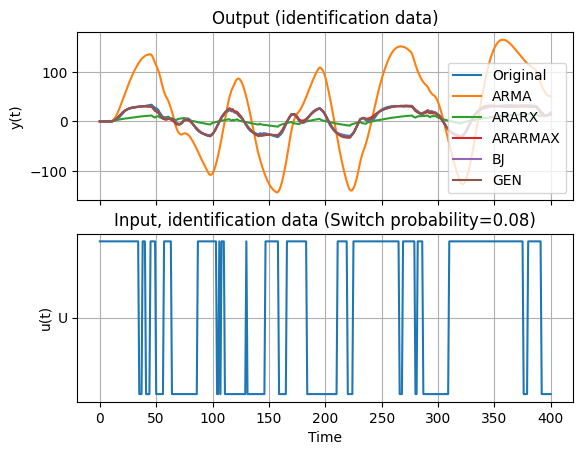

In [31]:
# Plot consistency of identified systems
fig = plot_response(
    time,
    ys,
    Usim,
    legends=[
        ["Original"] + [model.__class__.__name__ for model in models],
        ["U"],
    ],
    titles=[
        "Output (identification data)",
        "Input, identification data (Switch probability=0.08)",
    ],
)

In [34]:
# Validation of identified systems
switch_probability = 0.07
input_range = (0.5, 1.5)
noise_variance = 0.01
n_samples = 401
ts = 1.0
time, Ysimval, Usimval, g_sys, Yerrval, Uerrval, h_sys, Yval, Uval = (
    load_sample_siso(
        n_samples,
        ts,
        input_range=input_range,
        switch_probability=switch_probability,
        noise_variance=noise_variance,
        seed=0,
    )
)

ys = [sys.predict(Uval, safe=True) for sys in fitted_models]

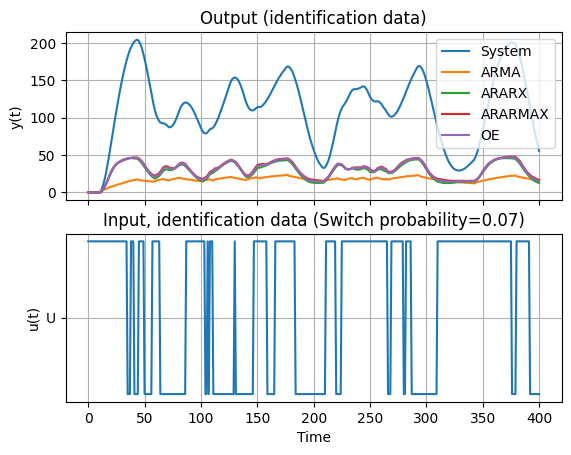

In [35]:
# Plot validation results
fig = plot_response(
    time,
    ys,
    Usim,
    legends=[ylegends, ["U"]],
    titles=[
        "Output (identification data)",
        "Input, identification data (Switch probability=0.07)",
    ],
)

In [19]:
# Print scores in a formatted table
print("Model Performance Metrics:")
print("-" * 50)
print(f"{'Model':<20} {'RMSE':<10} {'Explained Variance':<20}")
print("-" * 50)

for i, model_name in enumerate(ylegends):
    if i == 0:  # Skip the first one which is the actual data
        continue
    rmse_value = scores["rmse"][i - 1]
    ev_value = scores["ev"][i - 1]
    print(f"{model_name:<20} {rmse_value:<10.4f} {ev_value:<20.4f}")
print("-" * 50)


Model Performance Metrics:
--------------------------------------------------
Model                RMSE       Explained Variance  
--------------------------------------------------
ARMA                 72.6998    -10.7814            
ARARX                15.6436    0.4478              
ARARMAX              1.8726     0.9922              
OE                   3782356219418625540051622609007673319436632684400929676543852202837218541867329782938078573242260937016961530014830171689128391108542444597149696.0000 -34221366975772167174308513892133720443751464886247767979898042433728360162597569073150015188164778699093661026308306709668439155219534549065320181063382769701610823899049762639639982959390376442525214360956271029284966858077544319977427028692261534034824220216168441936142977550304411648.0000
BJ                   0.7089     0.9988              
GEN                  0.9157     0.9981              
--------------------------------------------------


/Users/mw/pyprojects/SIPPY/.venv/lib/python3.12/site-packages/control/lti.py:114: UserWarning: __call__: evaluation above Nyquist frequency
  warn("__call__: evaluation above Nyquist frequency")


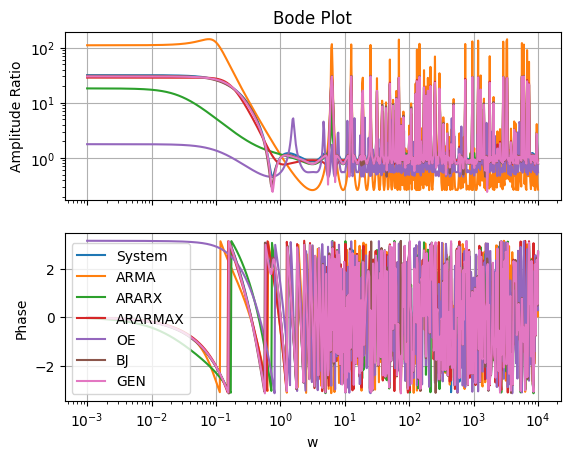

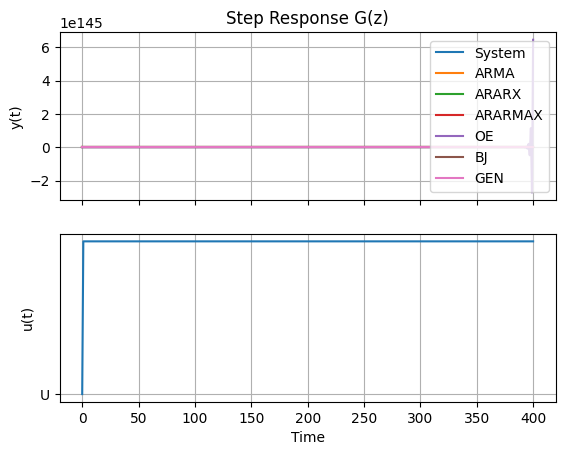

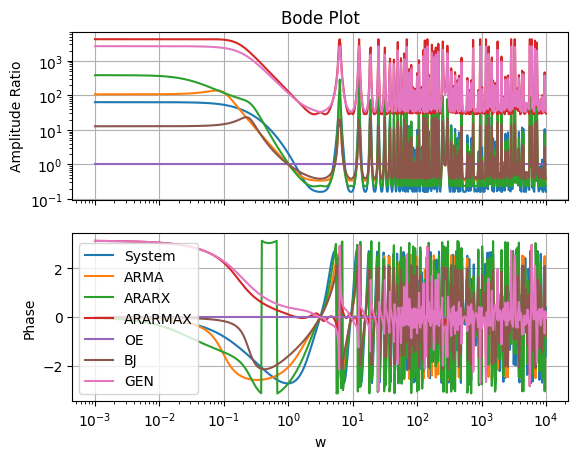

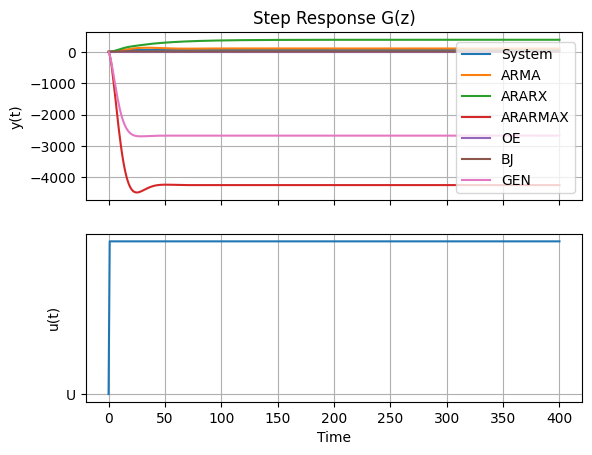

In [20]:
# Step tests
u = np.ones_like(time)
u[0] = 0
W_V = np.logspace(-3, 4, num=701)
for tf in ["G_", "H_"]:
    syss_tfs = [
        locals()[f"{tf.lower()}sys"],
        *[getattr(sys.steps[-1][1], tf) for sys in fitted_models],
    ]
    mags, fis, oms = zip(*[frequency_response(sys, W_V) for sys in syss_tfs])

    fig = plot_bode(
        oms[0],
        mags,
        fis,
        ylegends,
    )

    _, ys = zip(
        *[step_response(sys, time, transpose=True) for sys in syss_tfs]
    )

    fig = plot_response(
        time,
        ys,
        u,
        legends=[ylegends, ["U"]],
        titles=["Step Response G(z)", None],
    )